# Preparation for analysis

In [50]:
from sklearn.model_selection import train_test_split
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:

df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/feb/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')

def parse_distribution(dist_str):

    dist_list = ast.literal_eval(dist_str)  
    return dict(dist_list)

df['parsed_11'] = df['roberta-large-predictions'].apply(parse_distribution)
df['parsed_6'] = df['mapped_predictions'].apply(parse_distribution)


In [52]:
df_11 = pd.json_normalize(df['parsed_11'])
df_6  = pd.json_normalize(df['parsed_6'])


df_11.columns = [f"em_11_{col}" for col in df_11.columns] 
df_6.columns = [f"em_6_{col}" for col in df_6.columns]

df = pd.concat([df, df_11, df_6], axis=1)

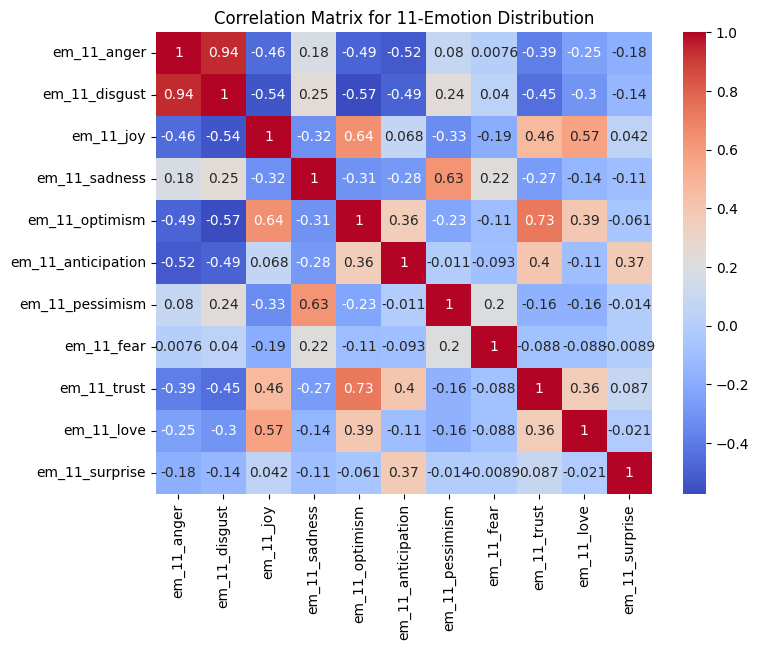

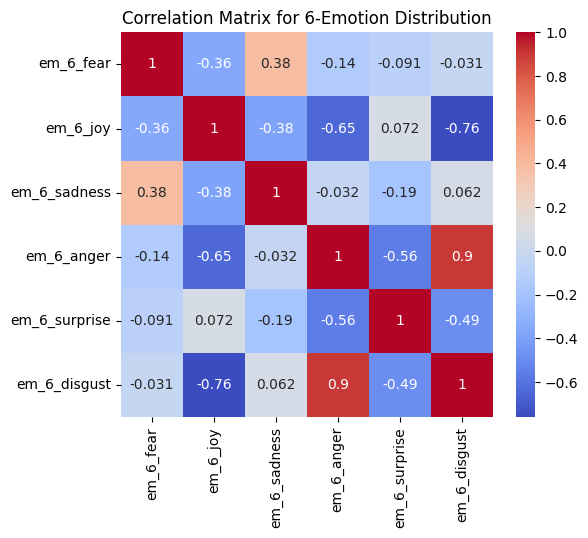

In [53]:
corr_11 = df[[col for col in df.columns if col.startswith("em_11_")]].corr()
corr_6 = df[[col for col in df.columns if col.startswith("em_6_")]].corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr_11, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for 11-Emotion Distribution")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(corr_6, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix for 6-Emotion Distribution")
plt.show()

In [54]:
replies_df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/feb/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')
tweets_df = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/feb/averaged_predictions.csv")

def parse_distribution(dist_str):
    return dict(ast.literal_eval(dist_str))

replies_df['label_distribution'] = replies_df['mapped_predictions'].apply(parse_distribution)
tweets_df['tweet_distribution'] = tweets_df['mapped_predictions'].apply(parse_distribution)
tweets_df['average_reply_distribution'] = tweets_df['averaged_predictions'].apply(parse_distribution)
tweets_df['clip_distribution'] = tweets_df['clip_predictions'].apply(parse_distribution)

In [55]:
def average_distributions(row):
    dist_1 = row['tweet_distribution']
    dist_2 = row['clip_distribution']
    avg_dist = {key: (dist_1[key] + dist_2[key]) / 2 for key in dist_1}
    return avg_dist
tweets_df['clip_tweet_dist'] = tweets_df.apply(average_distributions, axis=1)

In [56]:
from scipy.spatial.distance import jensenshannon

def compute_jsd(tweet_dist, reply_dist):
    tweet_probs = list(tweet_dist.values())
    reply_probs = list(reply_dist.values())
    return jensenshannon(tweet_probs, reply_probs, base=2)


In [57]:
tweets_df['jsd'] = tweets_df.apply(lambda row: compute_jsd(row['tweet_distribution'], row['average_reply_distribution']), axis=1)
tweets_df['jsd_image'] = tweets_df.apply(lambda row: compute_jsd(row['tweet_distribution'], row['clip_distribution']), axis=1)
tweets_df['jsd_multi'] = tweets_df.apply(lambda row: compute_jsd(row['clip_tweet_dist'], row['average_reply_distribution']), axis=1)

In [58]:
tweets_df['jsd_image_reply'] = tweets_df.apply(lambda row: compute_jsd(row['clip_distribution'], row['average_reply_distribution']), axis=1)

In [59]:
from scipy.stats import entropy

def compute_entropy(dist):
    probs = list(dist.values())
    return entropy(probs, base=2)

tweets_df['tweet_entropy'] = tweets_df['tweet_distribution'].apply(compute_entropy)
tweets_df['reply_entropy'] = tweets_df['average_reply_distribution'].apply(compute_entropy)
tweets_df['multi_entropy'] = tweets_df['clip_tweet_dist'].apply(compute_entropy)


In [60]:
grouped_replies = replies_df.groupby('conversation_id')


In [61]:
from itertools import combinations
import numpy as np

def pairwise_jsd(distributions):
    # Compute all pairwise JSD between distributions
    jsd_values = []
    for dist1, dist2 in combinations(distributions, 2):
        jsd = jensenshannon(list(dist1.values()), list(dist2.values()), base=2)
        jsd_values.append(jsd)
    return jsd_values

# Calculate pairwise JSD for replies of each tweet
reply_divergence = {}

for tweet_id, group in grouped_replies:
    reply_distributions = group['label_distribution'].tolist()
    jsd_values = pairwise_jsd(reply_distributions)
    reply_divergence[tweet_id] = {
        "mean_jsd": np.mean(jsd_values) if jsd_values else 0,
        "max_jsd": max(jsd_values) if jsd_values else 0,
        "pairwise_jsd": jsd_values
    }

# Convert to DataFrame for easier analysis
divergence_df = pd.DataFrame.from_dict(reply_divergence, orient='index')
divergence_df.reset_index(inplace=True)
divergence_df.rename(columns={"index": "conversation_id"}, inplace=True)


In [62]:
from scipy.spatial.distance import cosine

def calculate_cosine_similarity(row):
    dist_1 = row['average_reply_distribution']
    dist_2 = row['clip_tweet_dist']
    
    keys = sorted(dist_1.keys())
    vector_1 = [dist_1[key] for key in keys]
    vector_2 = [dist_2[key] for key in keys]
    
    return 1 - cosine(vector_1, vector_2)

tweets_df['cosine_similarity_multi'] = tweets_df.apply(calculate_cosine_similarity, axis=1)

In [63]:
tweets_df.head()

conversation_id                                         tweet_text  \
0  1091717129995542528  Energy Insider: Exploring the impact of winter...   
1  1092776506106015746  Given how what we eat (demand) determines what...   
2  1092784983998189568  New: [USER] PhD candidate Rodrigo Muñoz-Gonzál...   
3  1093132427810271233  See how Canada is addressing #ClimateChange th...   
4  1094070997135822848  You can kiss your beer goodbye if climate chan...   

                           roberta-large-predictions  \
0  [('anticipation', 0.578892707824707), ('sadnes...   
1  [('optimism', 0.9701303839683533), ('anticipat...   
2  [('anticipation', 0.6292991638183594), ('sadne...   
3  [('optimism', 0.9395819306373596), ('anticipat...   
4  [('sadness', 0.45861831307411194), ('disgust',...   

                                  mapped_predictions  \
0  [('fear', 0.10359434079474628), ('disgust', 0....   
1  [('fear', 0.0447722249566507), ('disgust', 0.0...   
2  [('fear', 0.03833197220923056), ('disgust', 0....   
3  [('fear', 0.019849522251128075), ('disgust', 0...   
4  [('fear', 0.22188846303966933), ('disgust', 0....   

                                averaged_predictions  \
0  [('fear', 0.017308233914370762), ('disgust', 0...   
1  [('fear', 0.005125462871671195), ('disgust', 0...   
2  [('fear', 0.008546253234571035), ('disgust', 0...   
3  [('fear', 0.07394002448004584), ('disgust', 0....   
4  [('fear', 0.026252819823070976), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.169931   
1                         0.927457   
2                         0.536289   
3                         0.901251   
4                         0.652959   

                                    clip_predictions  \
0  [('anger', 0.580223), ('disgust', 0.15167378),...   
1  [('fear', 0.32951933), ('surprise', 0.24203847...   
2  [('anger', 0.36482868), ('sadness', 0.2572939)...   
3  [('anger', 0.43142584), ('sadness', 0.28259405...   
4  [('anger', 0.31012434), ('fear', 0.2636976), (...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.860258                      0.237207   
1                        0.073772                      0.300501   
2                        0.212379                      0.281568   
3                        0.341340                      0.107704   
4                        0.748691                      0.889315   

                        matched_filename  ...  \
0  id_1091717129995542528_2019-02-02.jpg  ...   
1  id_1092776506106015746_2019-02-05.jpg  ...   
2  id_1092784983998189568_2019-02-05.jpg  ...   
3  id_1093132427810271233_2019-02-06.jpg  ...   
4  id_1094070997135822848_2019-02-09.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.580223, 'disgust': 0.15167378, 'su...   
1  {'fear': 0.32951933, 'surprise': 0.24203847, '...   
2  {'anger': 0.36482868, 'sadness': 0.2572939, 'd...   
3  {'anger': 0.43142584, 'sadness': 0.28259405, '...   
4  {'anger': 0.31012434, 'fear': 0.2636976, 'sadn...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.09813597539737313, 'disgust': 0.101...  0.743922  0.546684   
1  {'fear': 0.18714577747832534, 'disgust': 0.109...  0.289032  0.499172   
2  {'fear': 0.056366421104615275, 'disgust': 0.12...  0.499389  0.580781   
3  {'fear': 0.032529049625564035, 'disgust': 0.07...  0.436551  0.679329   
4  {'fear': 0.24279303151983467, 'disgust': 0.213...  0.479165  0.428556   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.478837         0.723585       1.894654       1.750250       2.322626   
1   0.555664         0.657211       1.483562       0.651996       2.306106   
2   0.533301         0.609168       1.675050       1.469118       2.382656   
3   0.307906         0.534690       1.228342       1.944429       2.302391   
4   0.439562         0.623316       2.281857       1.586454       2.305694   

   cos

In [64]:
divergence_df.to_csv("/work/ptyagi/masterthesis/data/predictions/feb/divergence.csv", index=False)
tweets_df.to_csv("/work/ptyagi/masterthesis/data/predictions/feb/analysis_metrics.csv", index=False)

# Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

In [3]:
tweets_df = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/feb/analysis_metrics.csv")
replies_df = pd.read_csv('/work/ptyagi/masterthesis/data/predictions/feb/predictions_replies_cardiffnlp_twitter-roberta-large-emotion-latest_merged.csv')
divergence_df = pd.read_csv("/work/ptyagi/masterthesis/data/predictions/feb/divergence.csv")

In [4]:
tweets_df.head(3)

conversation_id                                         tweet_text  \
0  1091717129995542528  Energy Insider: Exploring the impact of winter...   
1  1092776506106015746  Given how what we eat (demand) determines what...   
2  1092784983998189568  New: [USER] PhD candidate Rodrigo Muñoz-Gonzál...   

                           roberta-large-predictions  \
0  [('anticipation', 0.578892707824707), ('sadnes...   
1  [('optimism', 0.9701303839683533), ('anticipat...   
2  [('anticipation', 0.6292991638183594), ('sadne...   

                                  mapped_predictions  \
0  [('fear', 0.10359434079474628), ('disgust', 0....   
1  [('fear', 0.0447722249566507), ('disgust', 0.0...   
2  [('fear', 0.03833197220923056), ('disgust', 0....   

                                averaged_predictions  \
0  [('fear', 0.017308233914370762), ('disgust', 0...   
1  [('fear', 0.005125462871671195), ('disgust', 0...   
2  [('fear', 0.008546253234571035), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.169931   
1                         0.927457   
2                         0.536289   

                                    clip_predictions  \
0  [('anger', 0.580223), ('disgust', 0.15167378),...   
1  [('fear', 0.32951933), ('surprise', 0.24203847...   
2  [('anger', 0.36482868), ('sadness', 0.2572939)...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.860258                      0.237207   
1                        0.073772                      0.300501   
2                        0.212379                      0.281568   

                        matched_filename  ...  \
0  id_1091717129995542528_2019-02-02.jpg  ...   
1  id_1092776506106015746_2019-02-05.jpg  ...   
2  id_1092784983998189568_2019-02-05.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.580223, 'disgust': 0.15167378, 'su...   
1  {'fear': 0.32951933, 'surprise': 0.24203847, '...   
2  {'anger': 0.36482868, 'sadness': 0.2572939, 'd...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.09813597539737313, 'disgust': 0.101...  0.743922  0.546684   
1  {'fear': 0.18714577747832534, 'disgust': 0.109...  0.289032  0.499172   
2  {'fear': 0.056366421104615275, 'disgust': 0.12...  0.499389  0.580781   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.478837         0.723585       1.894654       1.750250       2.322626   
1   0.555664         0.657211       1.483562       0.651996       2.306106   
2   0.533301         0.609168       1.675050       1.469118       2.382656   

   cosine_similarity_multi  
0                 0.659882  
1                 0.693511  
2                 0.491588  

[3 rows x 22 columns]

In [5]:
divergence_df.head()

conversation_id  mean_jsd  max_jsd pairwise_jsd
0  1091717129995542528       0.0      0.0           []
1  1092776506106015746       0.0      0.0           []
2  1092784983998189568       0.0      0.0           []
3  1093132427810271233       0.0      0.0           []
4  1094070997135822848       0.0      0.0           []

In [6]:
high_jsd_tweets = tweets_df[tweets_df['jsd'] > 0.7] # with high divergence between tweet text and replies
high_jsd_tweets.reset_index(drop=True, inplace=True)

In [8]:
high_jsd_tweets.head(3)

conversation_id                                         tweet_text  \
0  1091717129995542528  Energy Insider: Exploring the impact of winter...   
1  1095973195683901440  The Kuwait Public Policy Center (KPPC) and UND...   
2  1095944493562556417  #AfrikaVuka our #valentine to fight #climatech...   

                           roberta-large-predictions  \
0  [('anticipation', 0.578892707824707), ('sadnes...   
1  [('anticipation', 0.9194981455802917), ('optim...   
2  [('optimism', 0.9372773766517639), ('joy', 0.8...   

                                  mapped_predictions  \
0  [('fear', 0.10359434079474628), ('disgust', 0....   
1  [('fear', 0.014205902403629789), ('disgust', 0...   
2  [('fear', 0.00798789328212195), ('disgust', 0....   

                                averaged_predictions  \
0  [('fear', 0.017308233914370762), ('disgust', 0...   
1  [('fear', 0.02311057996168319), ('disgust', 0....   
2  [('fear', 0.06355516923364243), ('disgust', 0....   

   cosine_similarity_tweet_replies  \
0                         0.169931   
1                         0.039631   
2                         0.192191   

                                    clip_predictions  \
0  [('anger', 0.580223), ('disgust', 0.15167378),...   
1  [('sadness', 0.40849605), ('anger', 0.2570026)...   
2  [('anger', 0.5701043), ('surprise', 0.16072159...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.860258                      0.237207   
1                        0.490406                      0.076119   
2                        0.909906                      0.037646   

                        matched_filename  ...  \
0  id_1091717129995542528_2019-02-02.jpg  ...   
1  id_1095973195683901440_2019-02-14.jpg  ...   
2  id_1095944493562556417_2019-02-14.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.580223, 'disgust': 0.15167378, 'su...   
1  {'sadness': 0.40849605, 'anger': 0.2570026, 'f...   
2  {'anger': 0.5701043, 'surprise': 0.16072159, '...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.09813597539737313, 'disgust': 0.101...  0.743922  0.546684   
1  {'fear': 0.11795768120181489, 'disgust': 0.037...  0.914577  0.652537   
2  {'fear': 0.027838274641060978, 'disgust': 0.07...  0.788622  0.733273   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.478837         0.723585       1.894654       1.750250       2.322626   
1   0.696242         0.697099       1.242375       1.496144       2.391716   
2   0.403266         0.612190       0.683524       2.311171       2.034477   

   cosine_similarity_multi  
0                 0.659882  
1                 0.320133  
2                 0.668004  

[3 rows x 22 columns]

In [7]:
high_jsd_replies = divergence_df[divergence_df['mean_jsd'] > 0.7] # high divergennce intra replies

In [12]:
high_jsd_replies_df = replies_df[replies_df['conversation_id'].isin(high_jsd_replies['conversation_id'])]
high_jsd_replies_df.reset_index(drop=True, inplace=True)

In [16]:
high_jsd_replies_df.head(3)

id      conversation_id                 created_at  \
0  1095930646671835136  1095926032505425921  2019-02-14 06:20:02+00:00   
1  1095941393745354752  1095940937698721793  2019-02-14 07:02:44+00:00   
2  1095941526423851008  1095940937698721793  2019-02-14 07:03:16+00:00   

        replies                                         tweet_text tweet_lang  \
0   Nailed it!!       WEATHER UPDATESource: AccuWeather[URL] [URL]         en   
1     thank you  Landscape-associated differences in fine-scale...         en   
2         Arson  Landscape-associated differences in fine-scale...         en   

   lang_confidence                          roberta-large-predictions  \
0         0.458873  [('joy', 0.957831859588623), ('optimism', 0.84...   
1         0.749205  [('joy', 0.9701732397079468), ('optimism', 0.7...   
2         0.749205  [('anger', 0.913879930973053), ('disgust', 0.5...   

                                  mapped_predictions  
0  [('fear', 0.016461996224881197), ('joy', 0.791...  
1  [('fear', 0.006845977231109438), ('joy', 0.951...  
2  [('fear', 0.1093412396137885), ('joy', 0.00763...

In [18]:
high_jsd_images_text = tweets_df[tweets_df['jsd_image'] > 0.7] # with high divergence between tweet text and clip
high_jsd_images_text.reset_index(drop=True, inplace=True)

In [19]:
high_jsd_images_text.head(3)

conversation_id                                         tweet_text  \
0  1095924262957928448  TV NIGHTS: Happy Valentine’s Day/Week!Read thi...   
1  1095959893389889536  Delighted to attend the Climate Change Forum i...   
2  1095955216589975552  How awesome are these #Castlemaine students! V...   

                           roberta-large-predictions  \
0  [('joy', 0.9261124730110168), ('optimism', 0.8...   
1  [('joy', 0.9925711750984192), ('optimism', 0.9...   
2  [('joy', 0.9980695843696594), ('optimism', 0.8...   

                                  mapped_predictions  \
0  [('fear', 0.003866702970204518), ('disgust', 0...   
1  [('fear', 0.005472744411696717), ('disgust', 0...   
2  [('fear', 0.004565565833562795), ('disgust', 0...   

                                averaged_predictions  \
0  [('fear', 0.006269783464926442), ('disgust', 0...   
1  [('fear', 0.08577749602512716), ('disgust', 0....   
2  [('fear', 0.009468419766569558), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.998888   
1                         0.978947   
2                         0.999574   

                                    clip_predictions  \
0  [('anger', 0.74721897), ('disgust', 0.07429857...   
1  [('fear', 0.47975126), ('disgust', 0.1508492),...   
2  [('fear', 0.6604705), ('anger', 0.13274965), (...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.060568                      0.062376   
1                        0.258106                      0.081556   
2                        0.024698                      0.023488   

                        matched_filename  ...  \
0  id_1095924262957928448_2019-02-14.jpg  ...   
1  id_1095959893389889536_2019-02-14.jpg  ...   
2  id_1095955216589975552_2019-02-14.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.74721897, 'disgust': 0.07429857, '...   
1  {'fear': 0.47975126, 'disgust': 0.1508492, 'an...   
2  {'fear': 0.6604705, 'anger': 0.13274965, 'surp...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.024913026485102262, 'disgust': 0.04...  0.050653  0.828873   
1  {'fear': 0.24261200220584836, 'disgust': 0.076...  0.305078  0.719334   
2  {'fear': 0.3325180329167814, 'disgust': 0.0411...  0.062845  0.806815   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.497987         0.827152       0.945945       0.978996       1.909572   
1   0.235574         0.514924       0.804189       1.796792       2.217081   
2   0.495136         0.802892       0.431266       0.390979       1.848969   

   cosine_similarity_multi  
0                 0.741449  
1                 0.925670  
2                 0.810310  

[3 rows x 22 columns]

In [20]:
high_jsd_images = tweets_df[tweets_df['jsd_image_reply'] > 0.7] # with high divergence between replies and clip
high_jsd_images.reset_index(drop=True, inplace=True)

In [22]:
high_jsd_images.head(3)

conversation_id                                         tweet_text  \
0  1091717129995542528  Energy Insider: Exploring the impact of winter...   
1  1095649500658577409  Thank you Hugo Metz [USER] for sharing insight...   
2  1095924262957928448  TV NIGHTS: Happy Valentine’s Day/Week!Read thi...   

                           roberta-large-predictions  \
0  [('anticipation', 0.578892707824707), ('sadnes...   
1  [('optimism', 0.9788973331451416), ('joy', 0.6...   
2  [('joy', 0.9261124730110168), ('optimism', 0.8...   

                                  mapped_predictions  \
0  [('fear', 0.10359434079474628), ('disgust', 0....   
1  [('fear', 0.021930042128382232), ('disgust', 0...   
2  [('fear', 0.003866702970204518), ('disgust', 0...   

                                averaged_predictions  \
0  [('fear', 0.017308233914370762), ('disgust', 0...   
1  [('fear', 0.004910594377697773), ('disgust', 0...   
2  [('fear', 0.006269783464926442), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.169931   
1                         0.991451   
2                         0.998888   

                                    clip_predictions  \
0  [('anger', 0.580223), ('disgust', 0.15167378),...   
1  [('anger', 0.36140743), ('fear', 0.28094196), ...   
2  [('anger', 0.74721897), ('disgust', 0.07429857...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.860258                      0.237207   
1                        0.278192                      0.308717   
2                        0.060568                      0.062376   

                        matched_filename  ...  \
0  id_1091717129995542528_2019-02-02.jpg  ...   
1  id_1095649500658577409_2019-02-13.jpg  ...   
2  id_1095924262957928448_2019-02-14.jpg  ...   

                                   clip_distribution  \
0  {'anger': 0.580223, 'disgust': 0.15167378, 'su...   
1  {'anger': 0.36140743, 'fear': 0.28094196, 'joy...   
2  {'anger': 0.74721897, 'disgust': 0.07429857, '...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.09813597539737313, 'disgust': 0.101...  0.743922  0.546684   
1  {'fear': 0.1514360010641911, 'disgust': 0.0269...  0.181942  0.696722   
2  {'fear': 0.024913026485102262, 'disgust': 0.04...  0.050653  0.828873   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.478837         0.723585       1.894654       1.750250       2.322626   
1   0.471275         0.763136       0.990289       0.509326       2.120975   
2   0.497987         0.827152       0.945945       0.978996       1.909572   

   cosine_similarity_multi  
0                 0.659882  
1                 0.878173  
2                 0.741449  

[3 rows x 22 columns]

In [23]:
high_jsd_combined = tweets_df[tweets_df['jsd_multi'] > 0.7] # with high divergence between replies and combined clip and text
high_jsd_combined.reset_index(drop=True, inplace=True)

In [25]:
high_jsd_combined.head(3)

conversation_id                                         tweet_text  \
0  1096376018343002112  This afternoon on [USER] at 1.55 in the East M...   
1  1096429597787344897  Parliament Square, 2019#protest #protestsigns ...   
2  1096454313076056067  Bunch of kids would do anything to get a day o...   

                           roberta-large-predictions  \
0  [('sadness', 0.6856414675712585), ('fear', 0.2...   
1  [('sadness', 0.5609669089317322), ('anger', 0....   
2  [('anger', 0.9920004606246948), ('disgust', 0....   

                                  mapped_predictions  \
0  [('fear', 0.18599664100932267), ('disgust', 0....   
1  [('fear', 0.0715077250766608), ('disgust', 0.1...   
2  [('fear', 0.01765352185538052), ('disgust', 0....   

                                averaged_predictions  \
0  [('fear', 0.0063848573097897545), ('disgust', ...   
1  [('fear', 0.018697702485806583), ('disgust', 0...   
2  [('fear', 0.011147999441702262), ('disgust', 0...   

   cosine_similarity_tweet_replies  \
0                         0.043644   
1                         0.337133   
2                         0.149256   

                                    clip_predictions  \
0  [('sadness', 0.28221118), ('fear', 0.22140914)...   
1  [('anger', 0.49430797), ('surprise', 0.1693815...   
2  [('anger', 0.52430594), ('sadness', 0.21374021...   

   cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
0                        0.273638                      0.879569   
1                        0.201498                      0.766066   
2                        0.209842                      0.807970   

                        matched_filename  ...  \
0  id_1096376018343002112_2019-02-15.jpg  ...   
1  id_1096429597787344897_2019-02-15.jpg  ...   
2  id_1096454313076056067_2019-02-15.jpg  ...   

                                   clip_distribution  \
0  {'sadness': 0.28221118, 'fear': 0.22140914, 'a...   
1  {'anger': 0.49430797, 'surprise': 0.16938154, ...   
2  {'anger': 0.52430594, 'sadness': 0.21374021, '...   

                                     clip_tweet_dist       jsd jsd_image  \
0  {'fear': 0.20370289050466134, 'disgust': 0.134...  0.915566  0.379215   
1  {'fear': 0.0859203375383304, 'disgust': 0.1376...  0.688299  0.534733   
2  {'fear': 0.03115534592769026, 'disgust': 0.223...  0.805439  0.680164   

   jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
0   0.849720         0.733755       2.159829       0.310373       2.388081   
1   0.702395         0.657658       2.322690       1.386289       2.322964   
2   0.765948         0.702010       1.897260       1.434184       2.031421   

   cosine_similarity_multi  
0                 0.155020  
1                 0.281060  
2                 0.189639  

[3 rows x 22 columns]

In [28]:
tweets_df[(tweets_df['jsd'] > 0.7) & (tweets_df['jsd_image_reply'] < 0.3)]

conversation_id                                         tweet_text  \
394   1096398745745408000  “There can be no sustainable econ growth w/o w...   
1656  1101068465039949824  4/4 [USER]: \The new, safer nuclear reactors t...   

                              roberta-large-predictions  \
394   [('optimism', 0.9866390228271484), ('anticipat...   
1656  [('anticipation', 0.9034678936004639), ('optim...   

                                     mapped_predictions  \
394   [('fear', 0.018522344818810377), ('disgust', 0...   
1656  [('fear', 0.02539539411730543), ('disgust', 0....   

                                   averaged_predictions  \
394   [('fear', 0.2996671284860745), ('disgust', 0.2...   
1656  [('fear', 0.39704822097077075), ('disgust', 0....   

      cosine_similarity_tweet_replies  \
394                          0.166844   
1656                         0.252243   

                                       clip_predictions  \
394   [('surprise', 0.25219026), ('anger', 0.2123019...   
1656  [('anger', 0.4915793), ('disgust', 0.17426959)...   

      cosine_similarity_clip_replies  cosine_similarity_clip_tweet  \
394                         0.758185                      0.365405   
1656                        0.670733                      0.164711   

                           matched_filename  ...  \
394   id_1096398745745408000_2019-02-15.jpg  ...   
1656  id_1101068465039949824_2019-02-28.jpg  ...   

                                      clip_distribution  \
394   {'surprise': 0.25219026, 'anger': 0.21230192, ...   
1656  {'anger': 0.4915793, 'disgust': 0.17426959, 'f...   

                                        clip_tweet_dist       jsd jsd_image  \
394   {'fear': 0.06906215490940519, 'disgust': 0.101...  0.814400  0.605127   
1656  {'fear': 0.07969250705865272, 'disgust': 0.091...  0.753114  0.688208   

      jsd_multi  jsd_image_reply  tweet_entropy  reply_entropy  multi_entropy  \
394    0.528802         0.288076       1.086886       2.288316       2.261335   
1656   0.468709         0.292057       1.259757       2.125241       2.308428   

      cosine_similarity_multi  
394                  0.454280  
1656                 0.571961  

[2 rows x 22 columns]

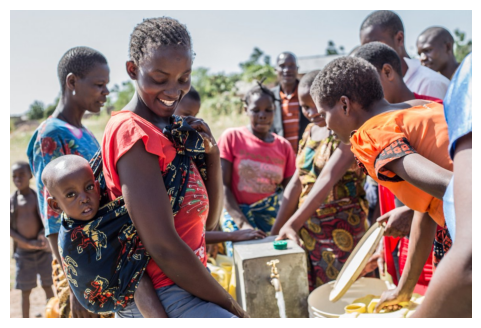

In [ ]:
path = "/work/ptyagi/ClimateVisions/Images/2019/02_February/id_1096398745745408000_2019-02-15.jpg"
image = Image.open(path)

# Set the figure size
plt.figure(figsize=(6, 4)) 
plt.imshow(image)
plt.axis('off')  # Remove axes for better visualization
plt.show()
print()

In [76]:
def plot_heatmap(jsd_values, reply_ids):
    heatmap_data = np.zeros((len(reply_ids), len(reply_ids)))
    idx = 0
    for i in range(len(reply_ids)):
        for j in range(i + 1, len(reply_ids)):
            heatmap_data[i, j] = jsd_values[idx]
            heatmap_data[j, i] = jsd_values[idx]
            idx += 1

    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, xticklabels=reply_ids, yticklabels=reply_ids, annot=True, cmap="coolwarm", cbar=True)
    plt.title("Pairwise JSD Heatmap for Replies")
    plt.xlabel("Replies")
    plt.ylabel("Replies")
    plt.show()


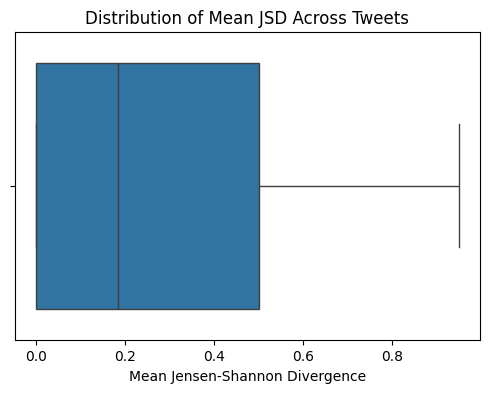

In [77]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=divergence_df, x='mean_jsd')
plt.title("Distribution of Mean JSD Across Tweets")
plt.xlabel("Mean Jensen-Shannon Divergence")
plt.show()


# Tweets with high divergence between tweet text and image predictions

In [3]:
def visualize_tweets(data, start_idx, end_idx, rows=2, cols=4):
    """
    Visualizes tweets and images for a specified index range.
    
    Parameters:
        data: DataFrame containing tweet information
        start_idx: Starting index of the range
        end_idx: Ending index of the range (exclusive)
        rows: Number of rows in the plot grid
        cols: Number of columns in the plot grid
    """
    batch_data = data.iloc[start_idx:end_idx]

    if batch_data.empty:
        print("No tweets found in the specified index range.")
        return

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
    axes = axes.flatten()  # Flatten for easy indexing

    for i, (index, row) in enumerate(batch_data.iterrows()):
        print(row['conversation_id'])

        # Get tweet details
        tweet_text = row["tweet_text"]
        tweet_distribution = row["tweet_distribution"]
        clip_distribution = row["clip_distribution"]
        avg_dist = row["average_reply_distribution"]
        image_path = f'/work/ptyagi/ClimateVisions/Images/2019/02_February/{row["matched_filename"]}'

        try:
            image = Image.open(image_path)
            axes[i].imshow(image)
            axes[i].axis('off')
            axes[i].set_title(f"Tweet ID: {row['conversation_id']}", fontsize=8)
        except FileNotFoundError:
            print(f"Image not found for conversation_id: {row['conversation_id']}")
            axes[i].axis('off')
            axes[i].set_title("Image Not Found", fontsize=8)

        # Print details in console for analysis
        print(f"Tweet {i + 1}: {tweet_text}")
        print(f"Tweet Distribution: {tweet_distribution}")
        print(f"CLIP Distribution: {clip_distribution}")
        print(f"reply Distribution: {avg_dist}")
        print("-" * 50)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
    plt.close(fig)  # Explicitly close the figure to release resources



1095984064274808832
Tweet 1: Here we go! Big turnout for [USER] 'Preparing Farm Businesses for a Changing Climate' [USER] #climatechange #foodsecurity [URL]
Tweet Distribution: {'fear': 0.022975509816043262, 'disgust': 0.0033704223855716537, 'joy': 0.6849917285802021, 'surprise': 0.28202611673539213, 'sadness': 0.004164893845658873, 'anger': 0.002471328637132043}
CLIP Distribution: {'anger': 0.8057025, 'disgust': 0.084594265, 'surprise': 0.051057145, 'sadness': 0.036693037, 'fear': 0.020711016, 'joy': 0.0012420081}
--------------------------------------------------
1095986244809605120
Tweet 2: Happy #valentines day! 💕Show some love to #nature today, by showing how much you care about the affects of #ClimateChange on the people, places and #wildlife you love. [USER]'s #ShowTheLove campaign has lots of things you can do to help,. [URL] [URL]
Tweet Distribution: {'fear': 0.011099804522567735, 'disgust': 0.002290118570047028, 'joy': 0.9277155613266367, 'surprise': 0.039277723603799095, 'sa

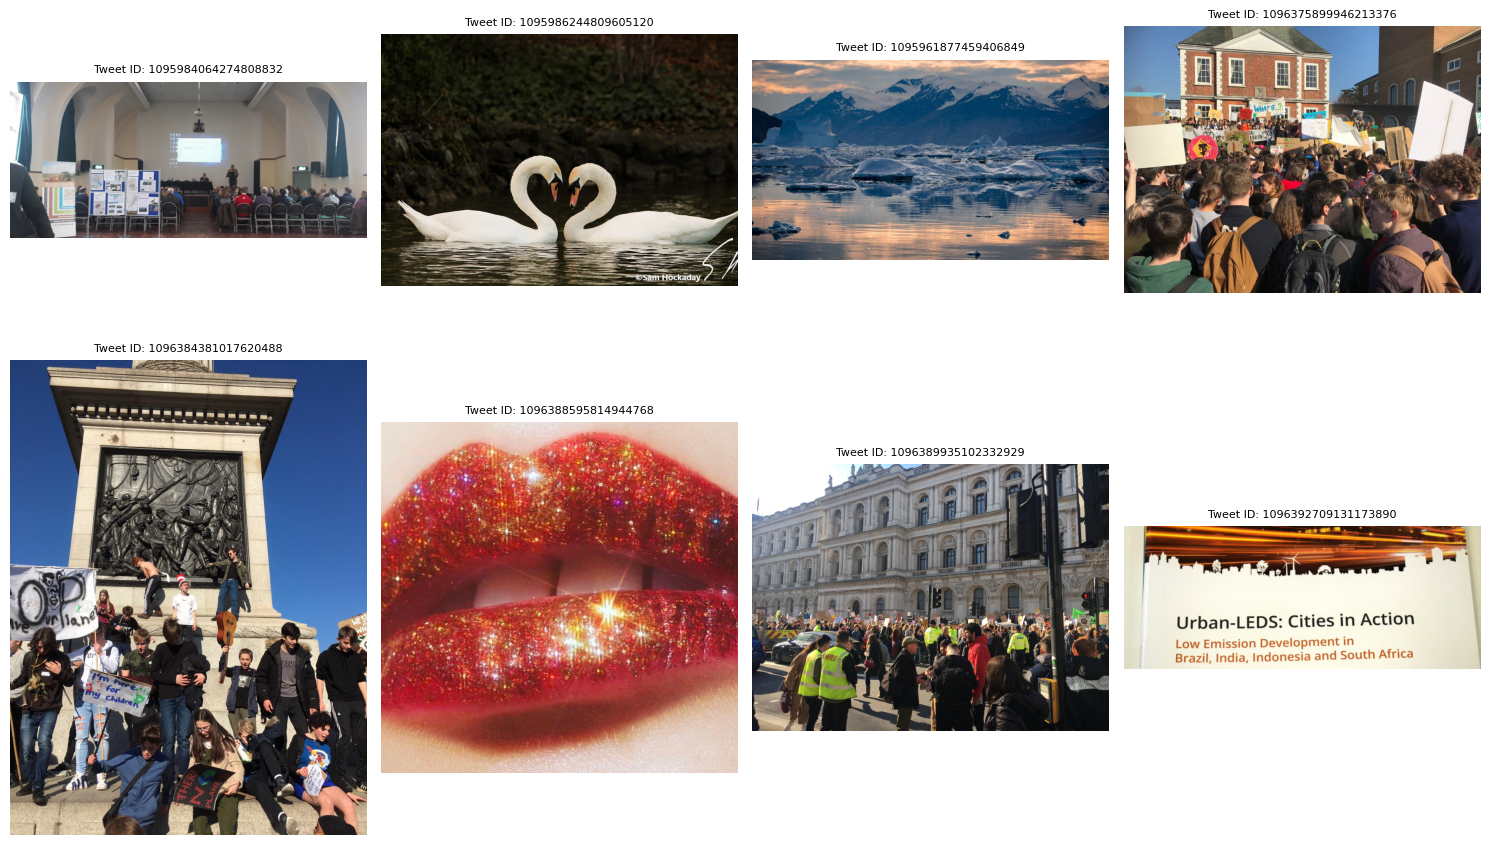

In [85]:
visualize_tweets(high_jsd_images, start_idx=8, end_idx=16)

In [86]:
low_jsd_images = tweets_df[tweets_df['jsd_image'] < 0.3]

In [87]:
low_jsd_images.reset_index(drop=True, inplace=True)

1097805912125902848
Tweet 1: At the start of Planetary Security Conference, [USER] shares his experience on how #ClimateChange and environmental damage fueled and resulted in conlicts in Bangladesh, Sudan and Iraq, before Dutch MFA minister   [USER] takes the floor #PSC19 [URL]
Tweet Distribution: {'fear': 0.2981726891237035, 'disgust': 0.10033476297844976, 'joy': 0.07752321326675204, 'surprise': 0.2191560529504403, 'sadness': 0.26431868384954665, 'anger': 0.04049459783110775}
CLIP Distribution: {'anger': 0.35699558, 'disgust': 0.26662388, 'surprise': 0.15496203, 'joy': 0.09638095, 'sadness': 0.09135859, 'fear': 0.033678923}
--------------------------------------------------
1097910354628280320
Tweet 2: Ending #ViolenceAgainstWomen and #Girls is NOT an isolated issue it interlinks with every facet of society#VAWG⛓️#SustainableDevelopment⛓️#Mental & #PhysicalHealth⛓️#Crime ⛓️#ClimateChange⛓️#EconomicSustainability⛓️#SocialandCultural #Norms⛓️#PopulationGrowth⛓️#HumanTrafficking [URL]
Tw

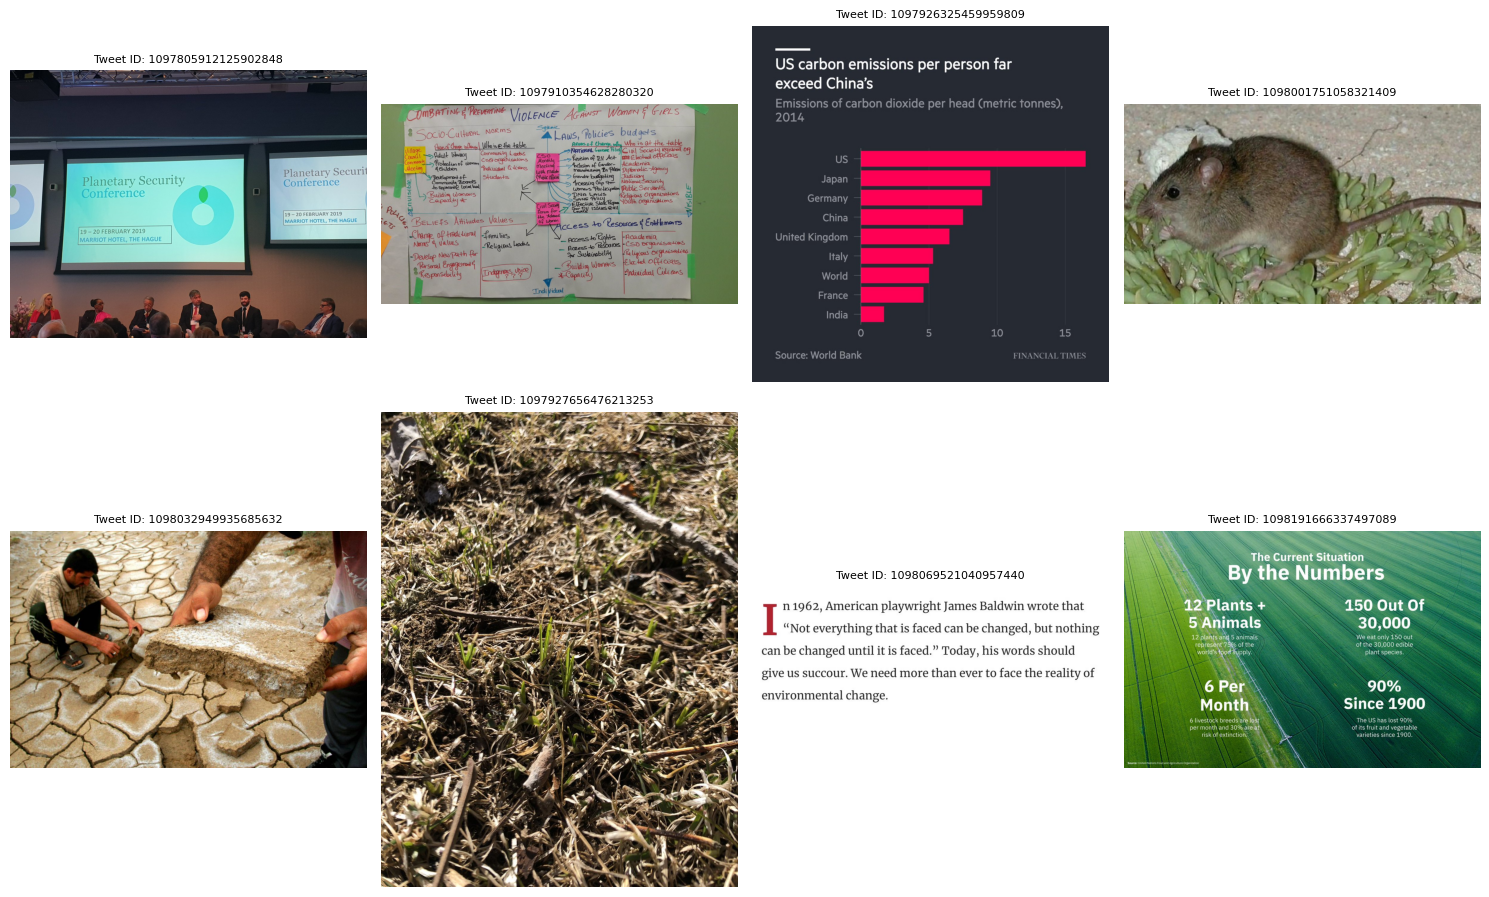

In [89]:
visualize_tweets(low_jsd_images, start_idx=16, end_idx=24)

# High JSD between labels and averge of clip and roberta

In [58]:
high_jsd_mutli = tweets_df[tweets_df['jsd_multi'] > 0.7]

In [59]:
high_jsd_mutli.reset_index(drop=True, inplace=True)


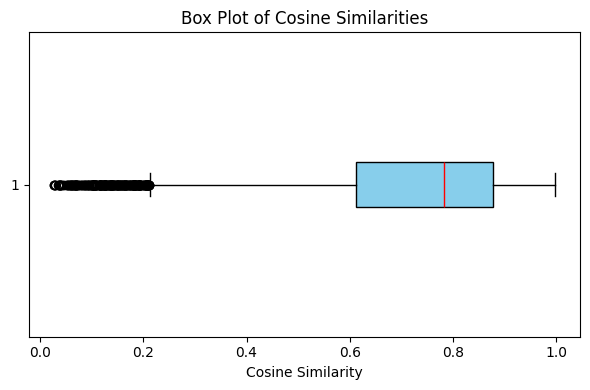

In [64]:
plt.figure(figsize=(6, 4))
plt.boxplot(tweets_df['cosine_similarity_multi'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.tight_layout()
plt.show()

In [65]:
train_data, temp_data = train_test_split(tweets_df, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

In [66]:
test_data['cosine_similarity_multi'].mean()

0.709041413816695

In [67]:
test_data["cosine_similarity_tweet_replies"].mean()

0.6919531516105084

In [68]:
test_data["cosine_similarity_clip_replies"].mean()

0.5017263212570278

In [72]:
high_jsd_replies_df

id      conversation_id                 created_at  \
278    1156847619412516865  1156845060081815552  2019-08-01 08:42:20+00:00   
281    1156848513805950976  1156845060081815552  2019-08-01 08:45:53+00:00   
297    1156853299691294720  1156852677080489984  2019-08-01 09:04:54+00:00   
313    1156856609701859328  1156852677080489984  2019-08-01 09:18:03+00:00   
591    1156928149927714816  1156922246008623104  2019-08-01 14:02:20+00:00   
...                    ...                  ...                        ...   
50889  1167857824426123264  1167855361111580673  2019-08-31 17:52:57+00:00   
50934  1167871656162807808  1167866241211486209  2019-08-31 18:47:55+00:00   
50959  1167879291394117633  1167866241211486209  2019-08-31 19:18:15+00:00   
50964  1167880550939389952  1167877914869690369  2019-08-31 19:23:16+00:00   
51046  1167905413875978240  1167877914869690369  2019-08-31 21:02:03+00:00   

                                                 replies  \
278                            Dede is a dream come true   
281    is this the same honorable person that yesterd...   
297    why is it that we got a nice bit of weather an...   
313    oh we will not but increasing sunshine is an i...   
591                               i use public transport   
...                                                  ...   
50889  they were not listening then and they are stil...   
50934           But has anyone asked you for an opinion?   
50959  thank you it was a great honour to sit and tal...   
50964  stick to the good work for charity prefer you ...   
51046  we did one of those last week but did not real...   

                                              tweet_text tweet_lang  \
278    Minister of Lands, Agriculture, Water,Climate ...         en   
281    Minister of Lands, Agriculture, Water,Climate ...         en   
297    UK #climatechange indicator 2018: 2018 was the...         en   
313    UK #climatechange indicator 2018: 2018 was the...         en   
591    It's now widely known #climatechange is the en...         en   
...                                                  ...        ...   
50889  Worth Another Look: 15 December 2015 UK MP Dav...         en   
50934  As the [USER] Secretary-General has noted,  wh...         en   
50959  As the [USER] Secretary-General has noted,  wh...         en   
50964  We were blessed with perfect Lake District wea...         en   
51046  We were blessed with perfect Lake District wea...         en   

       lang_confidence                          roberta-large-predictions  \
278           0.854413  [('joy', 0.993438184261322), ('optimism', 0.94...   
281           0.854413  [('anger', 0.8467773795127869), ('disgust', 0....   
297           0.795930  [('anger', 0.9557802677154541), ('disgust', 0....   
313           0.795930  [('optimism', 0.6479735374450684), ('anticipat...   
591           0.886806  [('sadness', 0.3003625273704529), ('disgust', ...   
...                ...                                                ...   
50889         0.668545  [('anger', 0.9648580551147461), ('disgust', 0....   
50934         0.888822  [('anticipation', 0.6487682461738586), ('sadne...   
50959         0.888822  [('joy', 0.9937946796417236), ('optimism', 0.9...   
50964         0.913983  [('optimism', 0.9680694341659546), ('joy', 0.9...   
51046         0.913983  [('fear', 0.9156543612480164), ('anticipation'...   

                                      mapped_predictions  
278    [('anger', 0.0020995781886712314), ('fear', 0....  
281    [('anger', 0.40751311635870957), ('fear', 0.01...  
297    [('anger', 0.31071780786018627), ('fear', 0.05...  
313    [('anger', 0.011548423393626045), ('fear', 0.0...  
591    [('anger', 0.07775364275222364), ('fear', 0.09...  
...                                                  ...  
50889  [('anger', 0.37458533103598635), ('fear', 0.06...  
50934  [('anger', 0.10394969983179918), ('fear', 0.11...  
50959  [('anger', 0.0020169371840837538), ('fear', 0.... 

In [74]:
filtered_df = high_jsd_replies_df[high_jsd_replies_df['conversation_id'] == 1156845060081815552]

print(filtered_df['tweet_text'].iloc[0])
print(filtered_df[['replies', 'mapped_predictions']].to_string(index=False))

Minister of Lands, Agriculture, Water,Climate and Rural Resettlement  Hon P. Shiri is attending a Green Climate Training Ceremony at Rainbow Towers,Harare.  Green Climate Finance Training is an intiative by private funders and Governments to fight the menace of climate change. [URL]
                                                                                         replies                                                                                                                                                                                        mapped_predictions
                                                                       Dede is a dream come true [('anger', 0.0020995781886712314), ('fear', 0.004812019753507222), ('surprise', 0.053412498880955596), ('disgust', 0.002211924590267632), ('sadness', 0.001636669135592898), ('joy', 0.9358273094510055)]
is this the same honorable person that yesterday called people in parliament monkeys and baboons   [('anger', 0.407513

In [1]:
import os

# Define the paths to the two directories
dir1 = "/work/ptyagi/masterthesis/src/runs/august_exp"
dir2 = "/work/ptyagi/masterthesis/src/runs/february_exp"

# Get filenames in each directory
files_dir1 = set(os.listdir(dir1))
files_dir2 = set(os.listdir(dir2))

# Find files that are unique to each directory
unique_to_dir1 = sorted(files_dir1 - files_dir2)
unique_to_dir2 = sorted(files_dir2 - files_dir1)

# Display the results
print("Files unique to Directory 1:")
for file in unique_to_dir1:
    print(file)


Files unique to Directory 1:
exp_adamw_only_vit_lr5e-06_drop0.3_epochs2_seed42
exp_adamw_only_vit_lr5e-06_drop0.3_epochs2_seed42_frozen
exp_adamw_only_vit_lr5e-06_drop0.3_epochs5_seed42
exp_adamw_only_vit_lr5e-06_drop0.3_epochs5_seed42_frozen
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs2_both_frozen
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs2_seed42
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs2_seed42_frozen_clip
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs2_seed42_frozen_roberta
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs5_both_frozen
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs5_seed42
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs5_seed42_frozen_clip
exp_adamw_roberta_base_lr1e-05_drop0.3_epochs5_seed42_frozen_roberta
exp_adamw_roberta_base_lr1e-05_drop0.5_epochs2_both_frozen
exp_adamw_roberta_base_lr1e-05_drop0.5_epochs2_seed42
exp_adamw_roberta_base_lr1e-05_drop0.5_epochs2_seed42_frozen_clip
exp_adamw_roberta_base_lr1e-05_drop0.5_epochs2_seed42_frozen_roberta
exp_adamw_rob

In [2]:
print("\nFiles unique to Directory 2:")
for file in unique_to_dir2:
    print(file)


Files unique to Directory 2:
exp_adamw_roberta_base_lr1e-05_drop0.3_bigger_mlp_epochs5_seed7
exp_adamw_roberta_base_lr1e-05_drop0.3_bigger_mlp_epochs5_seed7_frozen_roberta
exp_adamw_roberta_base_lr1e-05_drop0.5_bigger_mlp_epochs5_seed7
exp_adamw_roberta_base_lr1e-05_drop0.5_bigger_mlp_epochs5_seed7_frozen_roberta
exp_adamw_roberta_base_lr5e-06_drop0.3_bigger_mlp_epochs5_seed7
exp_adamw_roberta_base_lr5e-06_drop0.3_bigger_mlp_epochs5_seed7_frozen_roberta
exp_adamw_roberta_base_lr5e-06_drop0.5_bigger_mlp_epochs5_seed7
exp_adamw_roberta_base_lr5e-06_drop0.5_bigger_mlp_epochs5_seed7_frozen_clip
exp_adamw_roberta_base_lr5e-06_drop0.5_bigger_mlp_epochs5_seed7_frozen_roberta
